# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/vgg19_convlayers.png?raw=1' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/style_tx_cat.png?raw=1' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x584c2000 @  0x7f9d7666b2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [12]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 7.8MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [6]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:29<00:00, 19275290.16it/s]


In [7]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load in Content and Style Images

You can load in any images you want! Below, we've provided a helper function for loading in any type and size of image. The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

## Content and Style Features




In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21':'conv4_2',
                  '28': 'conv5_1'}
        
        
    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 




In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    _,d,h,w = tensor.size()
    tensor = tensor.view(d,h*w)
    ## get the batch_size, depth, height, and width of the Tensor
    ## reshape it, so we're multiplying the features for each channel
    ## calculate the gram matrix
    gram = torch.mm(tensor,tensor.t())
    
    return gram 

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [0]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

Below, you are given the option to weight the style representation at each relevant layer. It's suggested that you use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, you can expect to get _larger_ style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses

You'll decide on a number of steps for which to update your image, this is similar to the training loop that you've seen before, only we are changing our _target_ image and nothing else about VGG19 or any other image. Therefore, the number of steps is really up to you to set! **I recommend using at least 2000 steps for good results.** But, you may want to start out with fewer steps if you are just testing out different weight values or experimenting with different images.

Inside the iteration loop, you'll calculate the content and style losses and update your target image, accordingly.

#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary `style_weights`. 
> You'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. 
> Later, you'll see that this value is normalized by the size of the layer.

#### Total Loss

Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!

Intermittently, we'll print out this loss; don't be alarmed if the loss is very large. It takes some time for an image's style to change and you should focus on the appearance of your target image rather than any loss value. Still, you should see that this loss decreases over some number of iterations.



In [25]:
!wget https://images.sadhguru.org/sites/default/files/media_files/iso/en/45228-one-couple-two-spiritual-paths.jpg

--2019-01-21 19:14:38--  https://images.sadhguru.org/sites/default/files/media_files/iso/en/45228-one-couple-two-spiritual-paths.jpg
Resolving images.sadhguru.org (images.sadhguru.org)... 99.84.194.97, 99.84.194.92, 99.84.194.22, ...
Connecting to images.sadhguru.org (images.sadhguru.org)|99.84.194.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64106 (63K) [image/jpeg]
Saving to: ‘45228-one-couple-two-spiritual-paths.jpg’

45228-one-couple-tw 100%[===================>]  62.60K   192KB/s    in 0.3s    

2019-01-21 19:14:38 (192 KB/s) - ‘45228-one-couple-two-spiritual-paths.jpg’ saved [64106/64106]



In [28]:
!wget https://www.planwallpaper.com/static/images/colorful-nature-wallpaper.jpg

--2019-01-21 19:15:56--  https://www.planwallpaper.com/static/images/colorful-nature-wallpaper.jpg
Resolving www.planwallpaper.com (www.planwallpaper.com)... 104.24.126.96, 104.24.127.96, 2606:4700:30::6818:7e60, ...
Connecting to www.planwallpaper.com (www.planwallpaper.com)|104.24.126.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541363 (529K) [image/jpeg]
Saving to: ‘colorful-nature-wallpaper.jpg’

colorful-nature-wal 100%[===================>] 528.67K   493KB/s    in 1.1s    

2019-01-21 19:15:57 (493 KB/s) - ‘colorful-nature-wallpaper.jpg’ saved [541363/541363]



In [0]:
# load in content and style image
content = load_image('45228-one-couple-two-spiritual-paths.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('colorful-nature-wallpaper.jpg', shape=content.shape[-2:]).to(device)

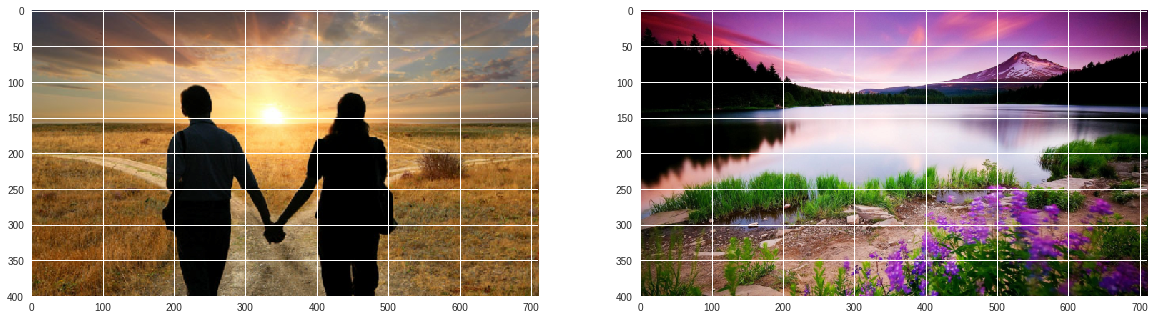

In [31]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

Total loss:  15743432.0


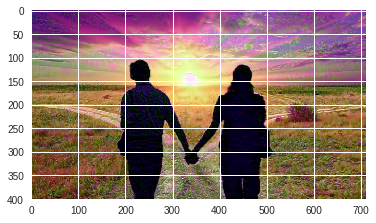

Total loss:  5323289.5


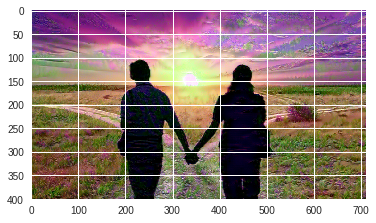

Total loss:  2734564.0


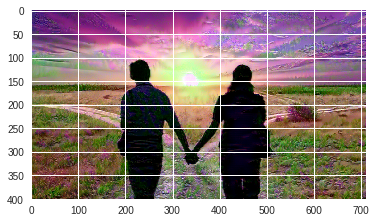

Total loss:  1722984.25


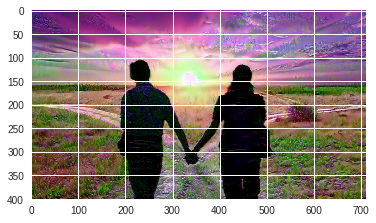

Total loss:  1198419.75


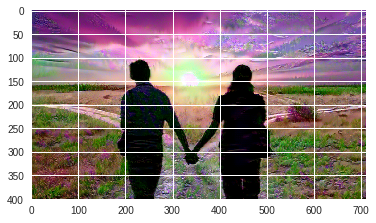

In [33]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    ## get the features from your target image    
    ## Then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        ## the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        ## get the "style" style representation
        style_feature = style_features[layer]
        style_gram = gram_matrix(style_feature)
        ## the style loss for one layer, weighted appropriately
        layer_style_weight = style_weights[layer]
        layer_style_loss = layer_style_weight * torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    ## the *total* loss
    total_loss = (content_weight * content_loss) + (style_weight * style_loss)
    
   
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

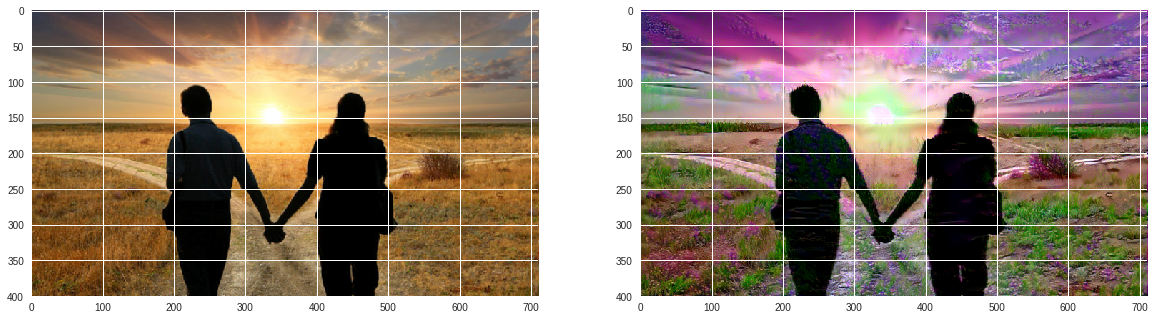

In [35]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))